In [2]:
# Importing required libraries and setting the directory path

import tensorflow as tf
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import model_from_json
import datetime
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
#from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import Callback
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score

%matplotlib inline

#folder_path = os.path.join(os.getcwd(), 'datasets/bitbrains/fastStorage/2013-8/')
july = os.path.join(os.getcwd(), 'datasets/bitbrains/rnd/2013-7/')
august = os.path.join(os.getcwd(), 'datasets/bitbrains/rnd/2013-8/')
septempber = os.path.join(os.getcwd(), 'datasets/bitbrains/rnd/2013-9/')

2024-07-28 17:02:48.019363: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-28 17:02:48.045633: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 17:02:48.045656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 17:02:48.046381: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-28 17:02:48.051314: I tensorflow/core/platform/cpu_feature_guar

In [3]:
def df_processing(df):

    df.columns = df.columns.str.replace('\t', '')

    df.insert(0, "DateTime", df['Timestamp [ms]'].apply(lambda x: datetime.datetime.fromtimestamp(x).replace(second=0, microsecond=0)))
    df = df.drop(columns=['Timestamp [ms]'])
    df.set_index('DateTime', inplace=True)
    df = df.sort_index()
    df = df.resample('5min').ffill()
    return df

df2_july = pd.read_csv(os.path.join(july, '383.csv'), sep=';')
df2_aug = pd.read_csv(os.path.join(august, '383.csv'), sep=';')
df2_sep = pd.read_csv(os.path.join(septempber, '383.csv'), sep=';')

df4_july = pd.read_csv(os.path.join(july, '392.csv'), sep=';')
df4_aug = pd.read_csv(os.path.join(august, '392.csv'), sep=';')
df4_sep = pd.read_csv(os.path.join(septempber, '392.csv'), sep=';')

df6_july = pd.read_csv(os.path.join(july, '386.csv'), sep=';')
df6_aug = pd.read_csv(os.path.join(august, '386.csv'), sep=';')
df6_sep = pd.read_csv(os.path.join(septempber, '386.csv'), sep=';')

dfs2_list = [df2_july, df2_aug, df2_sep]
dfs4_list = [df4_july, df4_aug, df4_sep]
dfs6_list = [df6_july, df6_aug, df6_sep]

dfs2 = [df_processing(df) for df in dfs2_list]
dfs4 = [df_processing(df) for df in dfs4_list]
dfs6 = [df_processing(df) for df in dfs6_list]

df2 = pd.concat(dfs2)
df2 = df2.bfill()
df4 = pd.concat(dfs4)
df4 = df4.bfill()
df6 = pd.concat(dfs6)
df6 = df6.bfill()


In [4]:
def fill_missing(df, start, end):
    df.reset_index(inplace=True)

    # Identify the previous day's period for replication
    previous_day_start = start - pd.DateOffset(days=1)
    previous_day_end = end - pd.DateOffset(days=1)

    # Filter the DataFrame to get the previous day's data
    previous_day_data = df[(df['DateTime'] >= previous_day_start) & (df['DateTime'] <= previous_day_end)]

    # Generate new timestamps for the missing period
    missing_period_timestamps = pd.date_range(start=start, end=end, freq='5min')

    # Replicate the previous day's data to the missing period
    replicated_data = previous_day_data.copy()
    replicated_data['DateTime'] = missing_period_timestamps[:len(previous_day_data)]

    # Concatenate the replicated data with the original DataFrame
    df_filled = pd.concat([df, replicated_data]).sort_values(by='DateTime').reset_index(drop=True)
    df_filled.set_index('DateTime', inplace=True)

    return df_filled

start_july = pd.to_datetime('2013-07-30 23:00:00')
end_july = pd.to_datetime('2013-07-31 23:00:00')
start_aug = pd.to_datetime('2013-08-30 23:00:00')
end_aug = pd.to_datetime('2013-08-31 23:00:00')
df2 = fill_missing(df2, start_july, end_july)
df2 = fill_missing(df2, start_aug, end_aug)
df4 = fill_missing(df4, start_july, end_july)
df4 = fill_missing(df4, start_aug, end_aug)
df6 = fill_missing(df6, start_july, end_july)
df6 = fill_missing(df6, start_aug, end_aug)

df_list = [df2, df4, df6]
merged_df = pd.concat(df_list)

merged_df = merged_df.sort_index()
df = merged_df
df = df[['CPU cores', 'CPU usage [%]']]
df = df[df.index > '2013-06-30 23:55:00']
df.reset_index(inplace=True)
df.sort_values(by=['DateTime', 'CPU cores'], inplace=True)
#df.rename(columns={"CPU cores": "unique_id", "DateTime": "ds", "CPU usage [%]": "y"}, inplace=True)
df.head(12)

,DateTime,CPU cores,CPU usage [%]
0,2013-07-01 00:00:00,2.0,17.300000
2,2013-07-01 00:00:00,4.0,9.983333
1,2013-07-01 00:00:00,6.0,40.777778
5,2013-07-01 00:05:00,2.0,20.600000
4,2013-07-01 00:05:00,4.0,27.833333
3,2013-07-01 00:05:00,6.0,41.311111
7,2013-07-01 00:10:00,2.0,17.566667
6,2013-07-01 00:10:00,4.0,50.433333
8,2013-07-01 00:10:00,6.0,37.333333
10,2013-07-01 00:15:00,2.0,18.233333


In [5]:
def feature_eng(df0):
    # Feature Engineering
    #df0['year'] = df0['DateTime'].dt.year
    df0['month'] = df0['DateTime'].dt.month
    df0['day'] = df0['DateTime'].dt.day
    df0['hour'] = df0['DateTime'].dt.hour
    df0['minute'] = df0['DateTime'].dt.minute
    df0['dayofweek'] = df0['DateTime'].dt.dayofweek
    df0.drop(columns=['DateTime'], inplace=True)
    return df0

df = feature_eng(df)
#df_synth = feature_eng(df_synth)

In [6]:
def normalize(df):
    result = df.copy()
    #for feature_name in df.columns[:-1]:
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result
df_norm = normalize(df)
#df_synth_norm = normalize(df_synth)
df_norm.head()

,CPU cores,CPU usage [%],month,day,hour,minute,dayofweek
0,0.0,0.126083,0.0,0.0,0.0,0.000000,0.0
2,0.5,0.048859,0.0,0.0,0.0,0.000000,0.0
1,1.0,0.373880,0.0,0.0,0.0,0.000000,0.0
5,0.0,0.160913,0.0,0.0,0.0,0.090909,0.0
4,0.5,0.237258,0.0,0.0,0.0,0.090909,0.0


In [7]:
# Multi Step Ahead Prediction

features = ['CPU cores', 'month', 'day', 'hour', 'minute', 'dayofweek', 'CPU usage [%]']
def create_sequences(data, seq_length=288, future_steps=6):
    df_as_numpy = data.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_numpy) - seq_length - future_steps):
        row = df_as_numpy[i:i+seq_length]  # Input sequence
        X.append(row)
        label = df_as_numpy[i+seq_length:i+seq_length+future_steps, -1]  # Future steps for CPU usage
        y.append(label)
    return np.array(X), np.array(y)

input_data = df_norm[features]

# Create sequences with the desired look-back and prediction horizons
seq_length = 144  # for instance, 24 time steps (e.g., 2 hours if each step is 5 minutes)
future_steps = 18  # predict 6 future steps (e.g., 30 minutes ahead)

X, y = create_sequences(input_data, seq_length, future_steps)

In [8]:
X.shape, y.shape

((78426, 144, 7), (78426, 18))

In [9]:
# X_train = X[:70731]
# X_test = X[70731:]
# y_train = y[:70731]
# y_test = y[70731:]
# X_train.shape, y_train.shape, X_test.shape, y_test.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
#X_val, , y_val,  = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((70583, 144, 7), (70583, 18), (7843, 144, 7), (7843, 18))

In [16]:
## loading model
gru_model = load_model('models/gru/gru_paper.keras')
gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 144, 512)          800256    
                                                                 
 gru_5 (GRU)                 (None, 512)               1575936   
                                                                 
 dense_2 (Dense)             (None, 18)                9234      
                                                                 
Total params: 2385426 (9.10 MB)
Trainable params: 2385426 (9.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


246/246 [==============================] - 38s 152ms/step


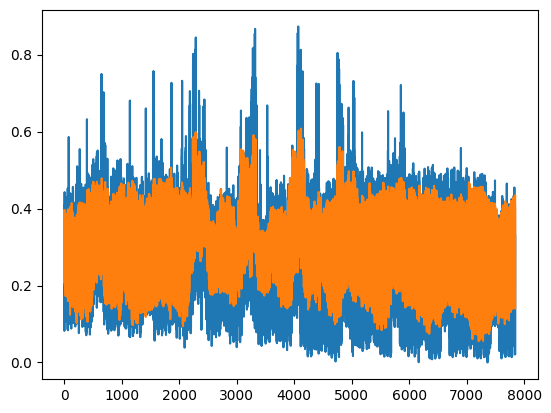

In [ ]:
def plot_predictions(model, X, y, tstart=0, tend=100):
    predictions =  model.predict(X)
    c_pred = predictions[:, 0]
    c_pred = c_pred.reshape(-1)
    c_actuals = y[:, 0]
    test_results = pd.DataFrame(data={'CPU Predictions': c_pred, 
                              'CPU Actuals':c_actuals
                                    })
    
    plt.plot(test_results['CPU Actuals'][tstart:tend], label='Actual')
    plt.plot(test_results['CPU Predictions'][tstart:tend], label='Prediction')

    return test_results[tstart:tend]
gru_result = plot_predictions(gru_model, X_test, y_test, tstart=0, tend=15000)

In [11]:
c_max = df['CPU usage [%]'].max()
c_min = df['CPU usage [%]'].min()


def denormalize(df):
    result = df.copy()
    result['CPU Predictions'] = df['CPU Predictions'] * (c_max - c_min) + c_min
    result['CPU Actuals'] = df['CPU Actuals'] * (c_max - c_min) + c_min
    
    return result
df_cm_denorm = denormalize(gru_result)
df_cm_denorm

NameError: name 'gru_result' is not defined

In [12]:
plt.figure(figsize=(16,5))
plt.plot(df_cm_denorm.index, df_cm_denorm['CPU Actuals'], label='CPU Actuals', color='orange')
plt.plot(df_cm_denorm.index, df_cm_denorm['CPU Predictions'], label='CPU Predictions', color='blue')
plt.xlabel('5 Minutes Sliced Time Intervals')
plt.ylabel('CPU Usage [%]')
plt.title('CPU Predictions and Actuals Comprison of Fast Storage')
plt.ylim([0,100])
plt.legend()

NameError: name 'df_cm_denorm' is not defined

<Figure size 1600x500 with 0 Axes>

In [13]:
# Evaluate the model
mse = mean_squared_error(df_cm_denorm['CPU Predictions'], df_cm_denorm['CPU Actuals'])
rmse = mse ** 0.5
print(f'Root Mean Squared Error: {rmse}')

NameError: name 'df_cm_denorm' is not defined

In [17]:
def calculate_rmse(predictions, actuals):
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    return rmse

def calculate_mae(predictions, actuals):
    mae = mean_absolute_error(actuals, predictions)
    return mae

def denormalize(predictions, actuals, c_max, c_min):
    denorm_predictions = predictions * (c_max - c_min) + c_min
    denorm_actuals = actuals * (c_max - c_min) + c_min
    return denorm_predictions, denorm_actuals

def plot_predictions(model, X, y, c_max, c_min, tstart=0, tend=500):
    predictions = model.predict(X)
    # Initialize an empty list to store RMSE values for each sequence
    rmse_values = []
    mae_values = []
    denorm_rmse_values = []
    denorm_mae_values = []
    
    for i in range(predictions.shape[0]):
        
        seq_pred = predictions[i]
        seq_actual = y[i]

        # De-normalize the predictions and actuals
        denorm_pred, denorm_actual = denormalize(seq_pred, seq_actual, c_max, c_min)
        
        # Calculate RMSE for de-normalized data
        denorm_rmse = calculate_rmse(denorm_pred, denorm_actual)
        denorm_rmse_values.append(denorm_rmse)

        denorm_mae = calculate_mae(denorm_pred, denorm_actual)
        denorm_mae_values.append(denorm_mae)
 
    overall_denorm_rmse = np.mean(denorm_rmse_values)
    overall_denorm_mae = np.mean(denorm_mae_values)

    dfnorm_pred_all, denorm_actuall_all = denormalize(predictions[:, 0], y[:,0], c_max, c_min)

    test_results_non_norm = pd.DataFrame({
        'CPU Predictions': dfnorm_pred_all,
        'CPU Actuals': denorm_actuall_all
    })
    
    return test_results_non_norm[tstart:tend], denorm_rmse_values, overall_denorm_rmse, denorm_mae_values, overall_denorm_mae

In [18]:
c_max = df['CPU usage [%]'].max()
c_min = df['CPU usage [%]'].min()

test_results_lstm, rmse_values_lstm, avg_rmse_lstm, mae_values_lstm, avg_mae_lstm = plot_predictions(gru_model, X_test, y_test, c_max, c_min, tstart=0, tend=15000)

246/246 [==============================] - 52s 211ms/step


In [19]:
test_results_lstm.tail(12)

,CPU Predictions,CPU Actuals
7831,34.375511,44.466667
7832,21.802923,15.933333
7833,42.713345,44.511111
7834,32.507950,42.766667
7835,20.722931,22.383333
7836,44.864883,34.633333
7837,32.123287,39.633333
7838,19.627283,10.133333
7839,43.254551,44.411111
7840,31.500357,35.866667


In [20]:
calculate_rmse(test_results_lstm['CPU Predictions'], test_results_lstm['CPU Actuals'])

8.80084277567743

In [21]:
calculate_mae(test_results_lstm['CPU Predictions'], test_results_lstm['CPU Actuals'])

6.853730926591573

In [22]:
r2 = r2_score(test_results_lstm['CPU Predictions'], test_results_lstm['CPU Actuals'])
print("R² score:", r2)

R² score: 0.29230397101286476


In [24]:
inf_time_lstm = []
for i in range(436):
    b_time = time.time()
    instance = X_test[i]
    instance_reshape = instance.reshape(1, instance.shape[0], instance.shape[1])
    gru_model.predict(instance_reshape)
    single_inftime = time.time() - b_time
    inf_time_lstm.append(single_inftime) 

1/1 [==============================] - 0s 53ms/step


In [25]:
np.mean(inf_time_lstm)

0.08357569274552372

In [20]:
# mili_inf_lstm = [x * 1000 for x in inf_time_lstm]
# mean_infer_lstm = sum(mili_inf_lstm) / len(mili_inf_lstm)
# mean_infer_lstm

In [21]:
# plt.plot(mili_inf_lstm)

# # Add titles and labels
# plt.title('Simple Line Plot')
# plt.xlabel('Index')
# plt.ylabel('Value')

# # Display the plot
# plt.show()

In [3]:
import numpy as np

(6, 1)

In [7]:
cpu = np.zeros((6, 1))
cpu.shape

(6, 1)